In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [4]:
class SentimentSchema(BaseModel):

    sentiment: Literal['positive', 'negative'] = Field(description="Sentiment of the review")

In [18]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [19]:
# Define model

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
structured_model = model.with_structured_output(SentimentSchema)
structured_model_for_diagnosis = model.with_structured_output(DiagnosisSchema)

In [11]:
prompt = f"I bought the new phone from flipkart and it is too good"

structured_model.invoke(prompt).sentiment

'positive'

In [12]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal['postive', 'negative']
    diagnosis: dict
    response: str

In [13]:
def get_sentiment(state: ReviewState) -> ReviewState:

    prompt = f"For the following review find the sentiment\n{state['review']}"
    output = structured_model.invoke(prompt)

    return {'sentiment': output.sentiment}

In [24]:
def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state: ReviewState) -> ReviewState:

    prompt = f"Write a warm thank you message in response to the review given below:\n{state['review']}\n Also kinldy ask to the user to leave feedback on our website"
    output = model.invoke(prompt).content

    return {'response': output}

def run_diagnosis(state: ReviewState) -> ReviewState:

    prompt = f"Diagnose this negative review:\n{state['review']}\n\n Return issue_type, tone and urgency"
    output = structured_model_for_diagnosis.invoke(prompt)

    return {'diagnosis': output.model_dump()}

def negative_reponse(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""
    You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """
    response = model.invoke(prompt).content

    return {'response': response}

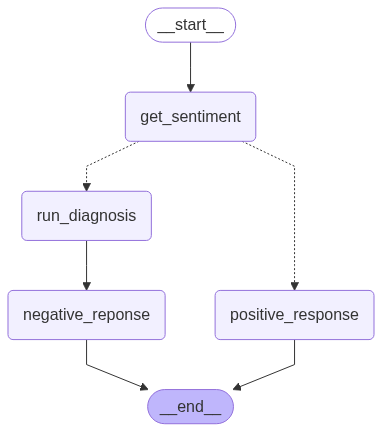

In [25]:
# Define graph
graph = StateGraph(ReviewState)

# Add nodes
graph.add_node('get_sentiment', get_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_reponse', negative_reponse)

# Add edges
graph.add_edge(START, 'get_sentiment')

graph.add_conditional_edges('get_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_reponse')
graph.add_edge('negative_reponse', END)

# Compile workflow
workflow = graph.compile()
workflow

In [27]:
# Define initial state

initial_state = {
    'review': 'The phone is really good and I want to buy it for my brother as well'
}

workflow.invoke(initial_state)

{'review': 'The phone is really good and I want to buy it for my brother as well',
 'sentiment': 'positive',
 'response': "Subject: Thank you for your wonderful review!\n\nDear [Customer Name],\n\nThank you so much for your fantastic review! We're thrilled to hear you're enjoying the phone and that you're considering buying another one for your brother. That's truly the best compliment we could receive!\n\nWe really appreciate you taking the time to share your positive experience.\n\nWe would also be incredibly grateful if you could share your feedback on our website at [Link to your website's review page]. Your opinion helps us improve and allows others to make informed decisions.\n\nThanks again for your support! We hope your brother loves the phone as much as you do.\n\nWarmly,\n\nThe [Your Company Name] Team"}